# Testing ARMA hidden semi-Markov models

In [1]:
import numpy as np
import seaborn as sns
import time

from types import SimpleNamespace

from bioslds import sources
from bioslds.arma import Arma, make_random_arma
from bioslds.arma_hsmm import sample_switching_models, ArmaHSMM
from bioslds.plotting import FigureManager

## Test `sample_switching_models`

### Generate a sawtooth signal

In [2]:
sawtooth = SimpleNamespace(
    arma1=Arma([1.0], [], bias=0.05, default_source=sources.Constant(0)),
    arma2=Arma([1.0], [], bias=-0.05, default_source=sources.Constant(0)),
    usage_seq=np.tile(np.repeat([0, 1], 20), 10),
)
sawtooth.n = len(sawtooth.usage_seq)

sawtooth.sig, _ = sample_switching_models(
    [sawtooth.arma1, sawtooth.arma2], sawtooth.usage_seq
)

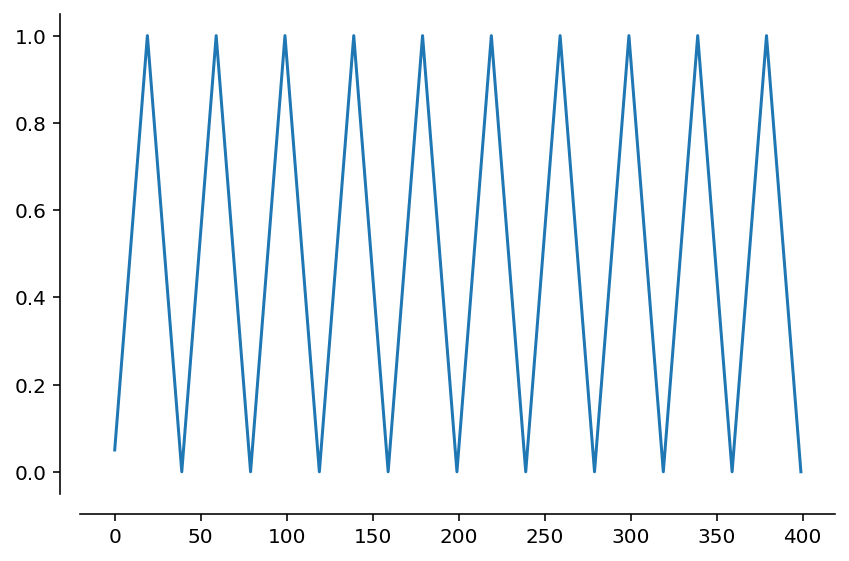

In [3]:
with FigureManager() as (_, ax):
    ax.plot(sawtooth.sig)

### Generate a noisy step signal

In [4]:
rng = np.random.default_rng(1)
noisy_step = SimpleNamespace(
    arma1=Arma([0.8], [], bias=1.0, default_source=sources.GaussianNoise(1, scale=0.1)),
    arma2=Arma([0.75], [], bias=-0.5, default_source=sources.GaussianNoise(2, scale=0.1)),
    arma3=Arma([0.85], [], bias=0.2, default_source=sources.GaussianNoise(3, scale=0.1)),
    usage_seq=np.repeat(rng.integers(low=0, high=3, size=10), 20),
)
noisy_step.n = len(sawtooth.usage_seq)

noisy_step.sig, _ = sample_switching_models(
    [noisy_step.arma1, noisy_step.arma2, noisy_step.arma3], noisy_step.usage_seq
)

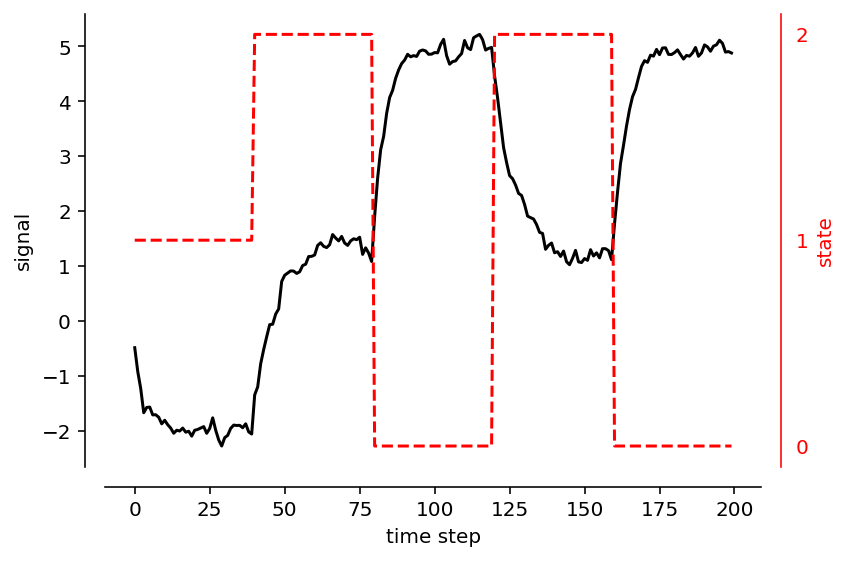

In [5]:
with FigureManager() as (_, ax):
    ax.plot(noisy_step.sig, "k")
    ax.set_xlabel("time step")
    ax.set_ylabel("signal")
    
    ax2 = ax.twinx()
    ax2.plot(noisy_step.usage_seq, c="r", ls="--")
    ax2.set_ylabel("state", color="r")
    ax2.tick_params(axis="y", labelcolor="r")
    ax2.spines["right"].set_color("r")
    
    ax2.set_yticks([0, 1, 2])
    sns.despine(ax=ax2, left=True, right=False, offset=10, bottom=True)

## Test `ArmaHSMM`

### Generate a signal with switching ARs, using minimal dwell time

In [6]:
random_switching = SimpleNamespace(
    arma1=Arma([0.8], [], default_source=sources.GaussianNoise(1)),
    arma2=Arma([-0.5], [], default_source=sources.GaussianNoise(2)),
    n=10000,
)

random_switching.arma_hsmm = ArmaHSMM(
    [random_switching.arma1, random_switching.arma2],
    min_dwell=15,
    dwell_times=[25, 35],
)

(
    random_switching.sig,
    random_switching.u,
    random_switching.usage_seq,
) = random_switching.arma_hsmm.transform(random_switching.n)

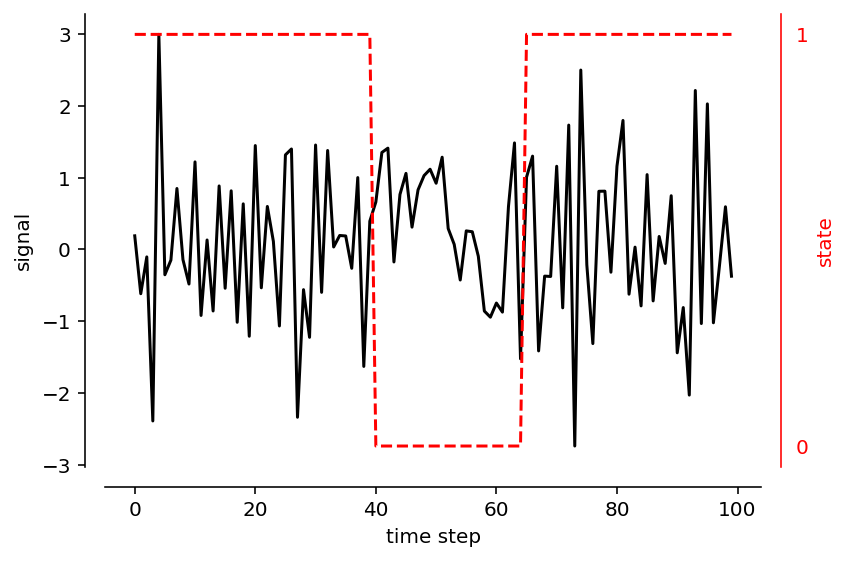

In [7]:
with FigureManager() as (_, ax):
    ax.plot(random_switching.sig[:100], "k")
    ax.set_xlabel("time step")
    ax.set_ylabel("signal")

    ax2 = ax.twinx()
    ax2.plot(random_switching.usage_seq[:100], c="r", ls="--")
    ax2.set_ylabel("state", color="r")
    ax2.tick_params(axis="y", labelcolor="r")
    ax2.spines["right"].set_color("r")

    ax2.set_yticks([0, 1])
    sns.despine(ax=ax2, left=True, right=False, offset=10, bottom=True)

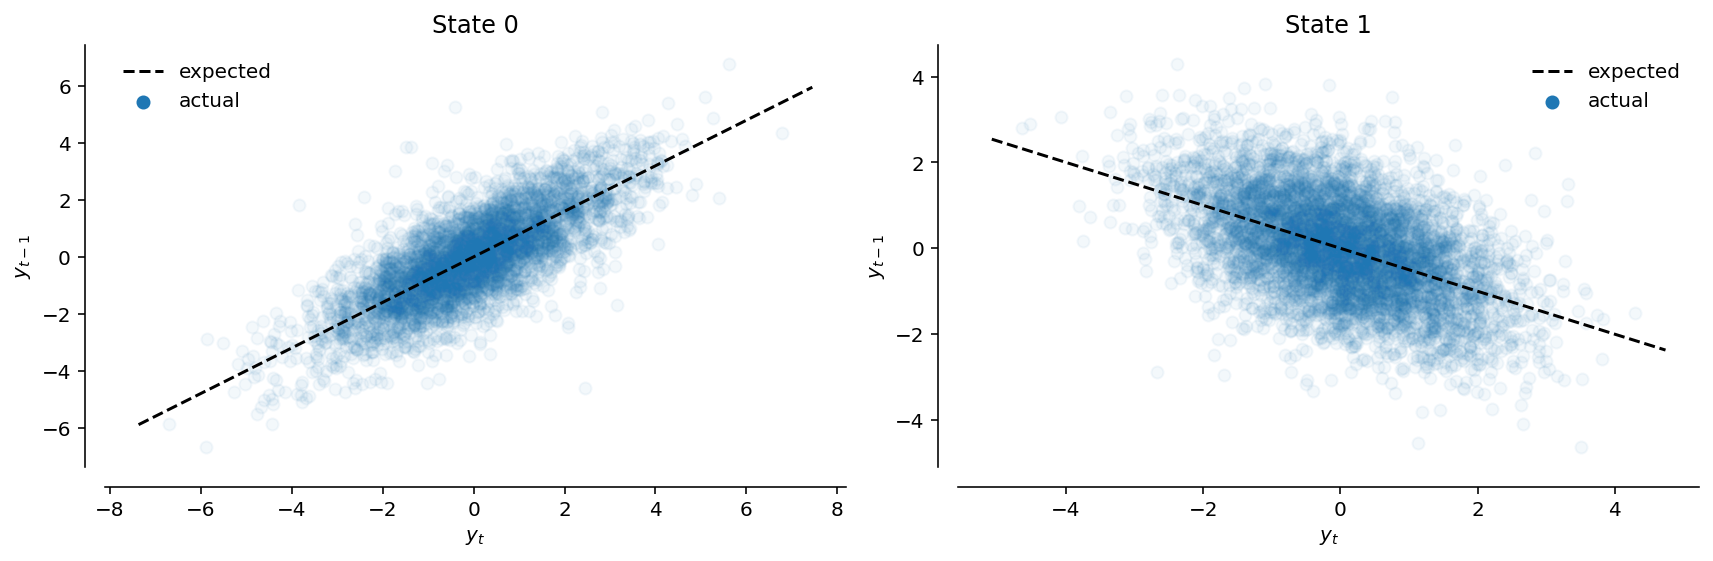

In [8]:
with FigureManager(1, 2) as (_, axs):
    for i, ax in enumerate(axs):
        crt_sig = random_switching.sig[random_switching.usage_seq == i]
        ax.scatter(crt_sig[1:], crt_sig[:-1], alpha=0.05, label="actual")
        xl = ax.get_xlim()
        ax.plot(
            xl,
            random_switching.arma_hsmm.models[i].a[0] * np.asarray(xl),
            "k--",
            label="expected",
        )

        leg_h = ax.legend(frameon=False)
        for crt_lh in leg_h.legendHandles:
            crt_lh.set_alpha(1)

        ax.set_xlabel("$y_t$")
        ax.set_ylabel("$y_{t-1}$")
        ax.set_title(f"State {i}")